## Linear Classification

`Objectives:`
- Linear Classification
- Loss Functions
 - Multi-class SVM Loss function (hinge loss)
 - Multi-class Logistic Regression loss function (cross-entopy or softmax)
- Optimization
- Gradient Descent Algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import classification_function_folder.layers
from classification_function_folder.data_utils import load_CIFAR10
 
plt.rcParams['figure.figsize'] = (12.0 , 6.0)   #set default size of plots
plt.rcParams['image.interpolation'] = 'spline16'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
np.set_printoptions(formatter={'all': lambda x: '%.2f' %x})

#### CIFAR-10 Data Loading and Preprocessing

In [ ]:
from classification_function_folder.data_utils import load_CIFAR10
cifar10_dir = './datasets/cifar-10-batches-py'
x_train , y_train , x_test , y_test = load_CIFAR10(cifar10_dir)

print("training data shape:      " , x_train.shape)
print("training labels shape:    " , y_train.shape)
print("test data shape:          " , x_test.shape)
print("test labels shape:        " , y_test.shape)

training data shape:       (50000, 32, 32, 3)
training labels shape:     (50000,)
test data shape:           (10000, 32, 32, 3)
test labels shape:         (10000,)


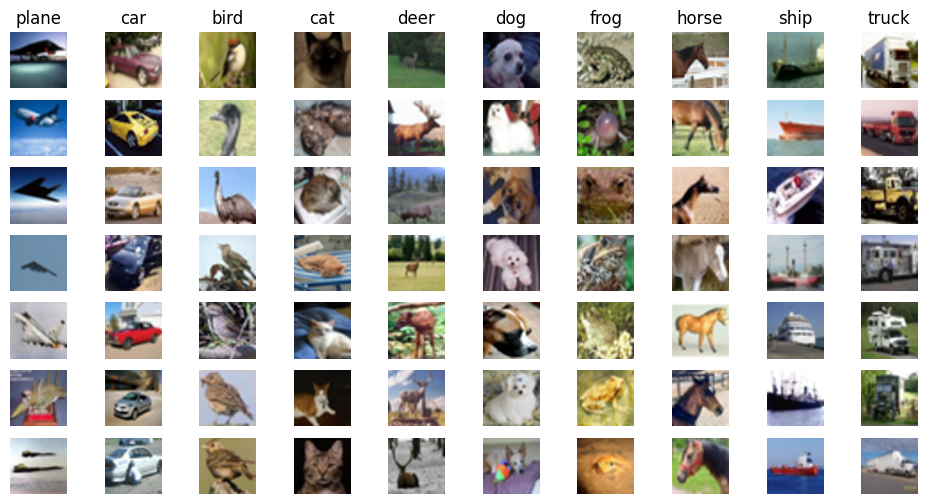

In [ ]:
#visualize some examples from the dataset.
#we show a few example of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.

mask = range(num_training , num_training + num_validation)
x_val = x_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.

mask = range(num_training)
x_train = x_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.

mask = np.random.choice(num_training , num_dev , replace=False)
x_dev = x_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.

mask = range(num_test)
x_test = x_test[mask]
y_test = y_test[mask]

print('train data shape       :' , x_train.shape)
print('train labels shape     :' , y_train.shape)
print('validation data shape  :' , x_val.shape)
print('validation data shape  :' , x_val.shape)
print('test data shape        :' , x_test.shape)
print('test data shape        :' , y_test.shape)

train data shape       : (49000, 32, 32, 3)
train labels shape     : (49000,)
validation data shape  : (1000, 32, 32, 3)
validation data shape  : (1000, 32, 32, 3)
test data shape        : (1000, 32, 32, 3)
test data shape        : (1000,)


In [ ]:
#preprocessing: reshape the image data into rows.
x_train = np.reshape(x_train , (x_train.shape[0] , -1))
x_val = np.reshape(x_val , (x_val.shape[0] , -1))
x_test = np.reshape(x_test , (x_test.shape[0] , -1))
x_dev = np.reshape(x_dev , (x_dev.shape[0] , -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', x_train.shape)
print('Validation data shape: ', x_val.shape)
print('Test data shape:       ', x_test.shape)
print('dev data shape:        ', x_dev.shape)

Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)
dev data shape:         (500, 3072)


[130.64 135.98 132.47 130.06 135.35 131.75 130.96 136.14 132.48 131.48]


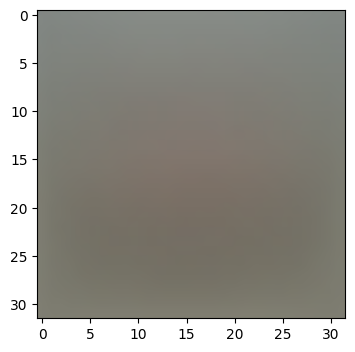

In [ ]:
#preprocessing: subtract the mean image
#first: copute the image mean based on the training data
mean_image = np.mean(x_train , axis=0)
print(mean_image[:10]) #print few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'))  #visualize the mean image
plt.show() 

In [ ]:
#second: subtract the mean image from train and test data
x_train -= mean_image
x_test -= mean_image
x_val -= mean_image
x_dev -= mean_image